In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/Colab Notebooks/normalizing-flows"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

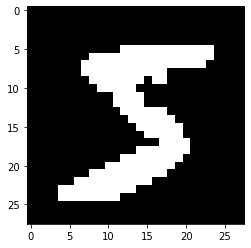

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train > 0).astype(np.float32)
X_test = (X_test > 0).astype(np.float32)
plt.imshow(X_train[0], cmap='gray')
x_train = np.expand_dims(X_train, axis=-1)
x_test = np.expand_dims(X_test, axis=-1)

In [4]:
def sample_digits_by_class(X, y, samples_per_class=1, classes=list(range(10))):
    samples = []
    labels = []
    for c in classes:
        match_inds = np.where(y.squeeze() == c)[0]
        sample_inds = np.random.choice(match_inds, size=samples_per_class, replace=False)
        samples.append(X[sample_inds])
        labels.append(y[sample_inds])
    return np.concatenate(samples, axis=0), np.concatenate(labels, axis=0)

In [5]:
def plot_images(x_test, x_pred):
    plt.subplot(2,4,1)
    plt.imshow(x_test[0], cmap='gray')
    plt.subplot(2,4,2)
    plt.imshow(x_test[1], cmap='gray')
    plt.subplot(2,4,3)
    plt.imshow(x_test[2], cmap='gray')
    plt.subplot(2,4,4)
    plt.imshow(x_test[3], cmap='gray')
    plt.subplot(2,4,5)
    plt.imshow(x_pred[0].squeeze(), cmap='gray')
    plt.subplot(2,4,6)
    plt.imshow(x_pred[1].squeeze(), cmap='gray')
    plt.subplot(2,4,7)
    plt.imshow(x_pred[2].squeeze(), cmap='gray')
    plt.subplot(2,4,8)
    plt.imshow(x_pred[3].squeeze(), cmap='gray')
    plt.show()

In [52]:
def plot_transforms(X, labels, vae, samples_per_input=1):
    if samples_per_input > 0:
        labels = np.repeat(labels, samples_per_input, axis=0)
    num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
    _, zs = vae.sample(X, n=samples_per_input)
    assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
    fig, axs = plt.subplots(1, num_transforms, figsize=(8*num_transforms,6))
    for i, z in enumerate(zs):
        ax = axs[i] if num_transforms > 1 else axs
        splot = ax.scatter(z[:,0], z[:,1], c=labels, cmap='tab10')
        ax.set_title('$z_{}$'.format(i))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

def plot_transforms_multi(X, labels, models, model_names, samples_per_input=1):
    assert len(models) == len(model_names)
    if samples_per_input > 0:
        labels = np.repeat(labels, samples_per_input, axis=0)
    num_transforms_ = max([vae.flow.num_flows + 1 for vae in models])
    fig, axs = plt.subplots(len(models), num_transforms_, figsize=(8*num_transforms_,6*len(models)))
    for i, (vae, name) in enumerate(zip(models, model_names)):
        num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
        _, zs = vae.sample(X, n=samples_per_input)
        assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
        for j, z in enumerate(zs):
            if num_transforms > 1 and len(models) > 1:
                ax = axs[i, j]
            elif len(models) > 1:
                ax = axs[i]
            elif num_transforms > 1:
                ax = axs[j]
            else:
                ax = axs
            splot = ax.scatter(z[:,0], z[:,1], c=labels, cmap='tab10')
            ax.set_title('{}, $z_{}$'.format(name, j))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

def plot_tsne_transforms(X, labels, vae, samples_per_input=1):
    from sklearn.manifold import TSNE
    from tqdm import tqdm
    num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
    _, zs = vae.sample(X, n=samples_per_input)
    assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
    if samples_per_input > 0:
        labels = np.repeat(labels, samples_per_input, axis=0)
    fig, axs = plt.subplots(1, num_transforms, figsize=(8*num_transforms,6))
    tsne = TSNE(n_components=2, perplexity=10)
    for i, z in tqdm(list(enumerate(zs)), desc='transforms'):
        ax = axs[i] if num_transforms > 1 else axs
        z_tsne = tsne.fit_transform(z)
        splot = ax.scatter(z_tsne[:,0], z_tsne[:,1], c=labels, cmap='tab10')
        ax.set_title('t-SNE mapped $z_{}$'.format(i))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

def plot_tsne_transforms_multi(X, labels, models, model_names, samples_per_input=1):
    from sklearn.manifold import TSNE
    from tqdm import tqdm
    assert len(models) == len(model_names)
    if samples_per_input > 0:
        labels = np.repeat(labels, samples_per_input, axis=0)
    num_transforms_ = max([vae.flow.num_flows + 1 for vae in models])
    fig, axs = plt.subplots(len(models), num_transforms_, figsize=(8*num_transforms_,6*len(models)))
    for i, (vae, name) in enumerate(zip(models, model_names)):
        num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
        _, zs = vae.sample(X, n=samples_per_input)
        assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
        tsne = TSNE(n_components=2, perplexity=10)
        for j, z in enumerate(zs):
            if num_transforms > 1 and len(models) > 1:
                ax = axs[i, j]
            elif len(models) > 1:
                ax = axs[i]
            elif num_transforms > 1:
                ax = axs[j]
            else:
                ax = axs
            z_tsne = tsne.fit_transform(z)
            splot = ax.scatter(z_tsne[:,0], z_tsne[:,1], c=labels, cmap='tab10')
            ax.set_title('{}, t-SNE mapped $z_{}$'.format(name, j))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

In [7]:
def train_vae(x_train, x_test, flow=None, z_size=16, n_epochs=10):
    beta_update = lambda i, beta: 1.0E-1*(i+1)
    vae = GatedConvVAE(x_train.shape[1], x_train.shape[2], flow, z_size=z_size, beta_update_fn=beta_update)
    vae.fit(x_train, x_train, epochs=n_epochs, batch_size=128, validation_data=(x_test, x_test))
    return vae

In [8]:
# sample balanced set of digits for transform plots
X_samples, y_samples = sample_digits_by_class(x_test, y_test, samples_per_class=100)

### Vanilla VAE

In [9]:
vae = train_vae(x_train, x_test, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 201us/sample - loss: 0.3104 - val_loss: 0.2611
Epoch 2/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2571 - val_loss: 0.2509
Epoch 3/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2475 - val_loss: 0.2432
Epoch 4/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2417 - val_loss: 0.2393
Epoch 5/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2371 - val_loss: 0.2341
Epoch 6/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2316 - val_loss: 0.2284
Epoch 7/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2266 - val_loss: 0.2230
Epoch 8/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2224 - val_loss: 0.2196
Epoch 9/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.2

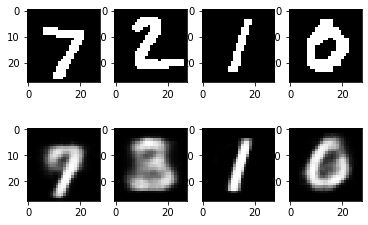

In [10]:
x_pred = vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

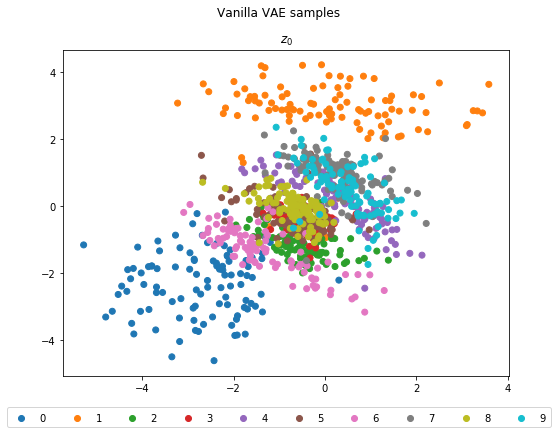

In [11]:
plot_transforms(X_samples, y_samples, vae)
plt.suptitle('Vanilla VAE samples')
plt.show()

In [12]:
vae_hiz = train_vae(x_train, x_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.2201 - val_loss: 0.1514
Epoch 2/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1431 - val_loss: 0.1338
Epoch 3/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1307 - val_loss: 0.1249
Epoch 4/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1236 - val_loss: 0.1190
Epoch 5/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1189 - val_loss: 0.1152
Epoch 6/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1156 - val_loss: 0.1128
Epoch 7/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1128 - val_loss: 0.1101
Epoch 8/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1107 - val_loss: 0.1079
Epoch 9/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1

transforms: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


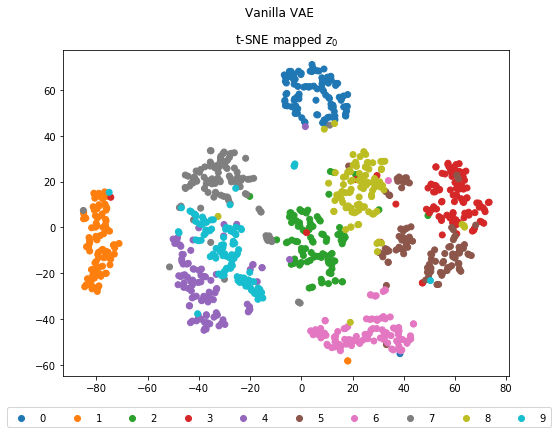

In [13]:
plot_tsne_transforms(X_samples, y_samples, vae_hiz)
plt.suptitle('Vanilla VAE')
plt.show()

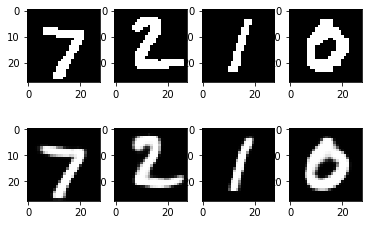

In [14]:
x_pred_vae = vae_hiz.predict(x_test)
plot_images(x_test.squeeze(), x_pred_vae)

### Planar VAE

In [15]:
n_flows = 4
planar_flow = Flow.uniform(n_flows, lambda i: Planar())
planar_vae = train_vae(x_train, x_test, planar_flow, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 215us/sample - loss: 0.3143 - val_loss: 0.2675
Epoch 2/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2593 - val_loss: 0.2516
Epoch 3/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2475 - val_loss: 0.2416
Epoch 4/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2379 - val_loss: 0.2323
Epoch 5/10
60000/60000 [==============================] - 8s 142us/sample - loss: 0.2296 - val_loss: 0.2238
Epoch 6/10
60000/60000 [==============================] - 8s 142us/sample - loss: 0.2200 - val_loss: 0.2143
Epoch 7/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2124 - val_loss: 0.2112
Epoch 8/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2090 - val_loss: 0.2076
Epoch 9/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2

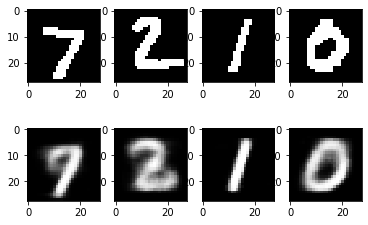

In [16]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = planar_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

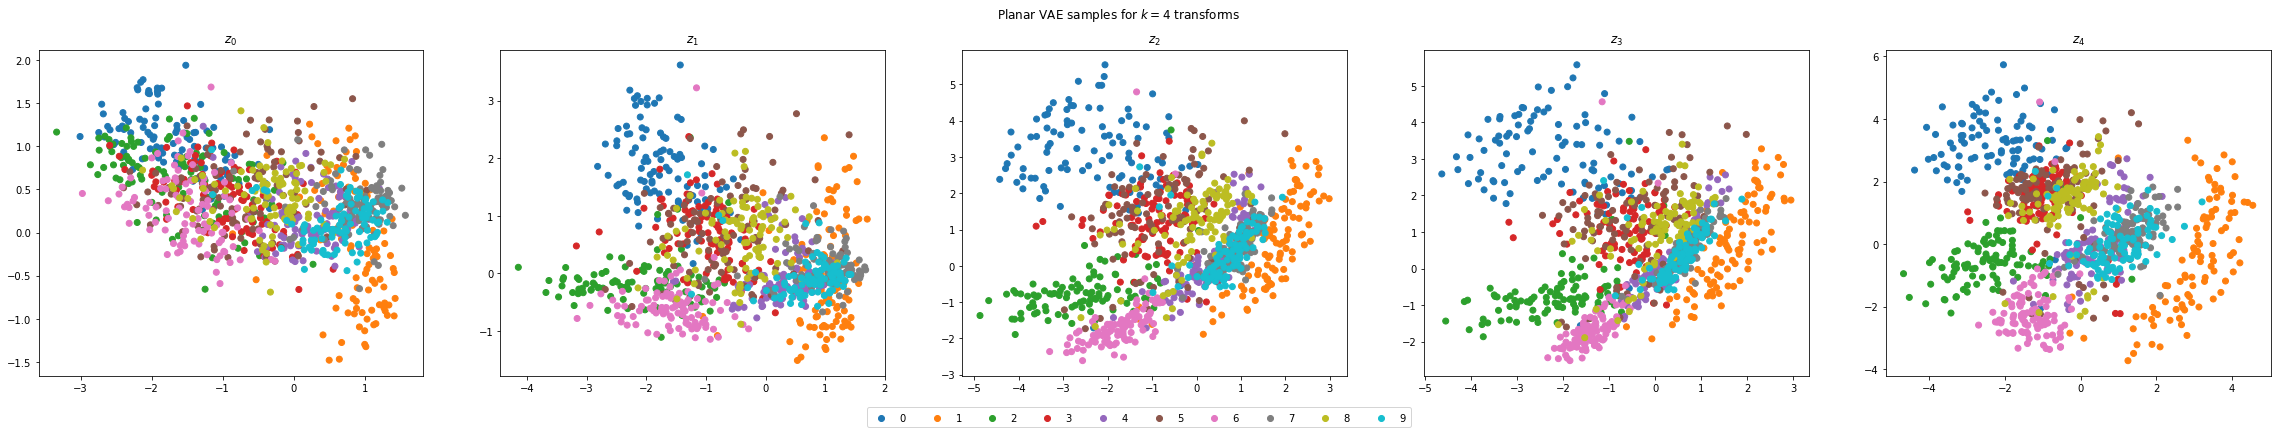

In [17]:
plot_transforms(X_samples, y_samples, planar_vae)
plt.suptitle('Planar VAE samples for $k={}$ transforms'.format(n_flows))
plt.show()

In [18]:
planar_vae_z16 = train_vae(x_train, x_test, planar_flow)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 216us/sample - loss: 0.2173 - val_loss: 0.1539
Epoch 2/10
60000/60000 [==============================] - 9s 145us/sample - loss: 0.1433 - val_loss: 0.1321
Epoch 3/10
60000/60000 [==============================] - 9s 144us/sample - loss: 0.1283 - val_loss: 0.1213
Epoch 4/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.1201 - val_loss: 0.1154
Epoch 5/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.1150 - val_loss: 0.1118
Epoch 6/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.1116 - val_loss: 0.1088
Epoch 7/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.1090 - val_loss: 0.1065
Epoch 8/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.1068 - val_loss: 0.1045
Epoch 9/10
60000/60000 [==============================] - 9s 144us/sample - loss: 0.1

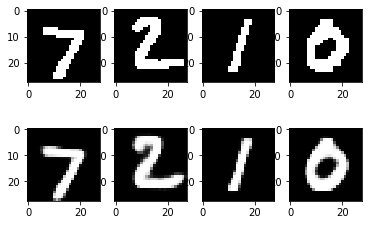

In [19]:
x_pred_planar = planar_vae_z16.predict(x_test)
plot_images(x_test.squeeze(), x_pred_planar)

transforms: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


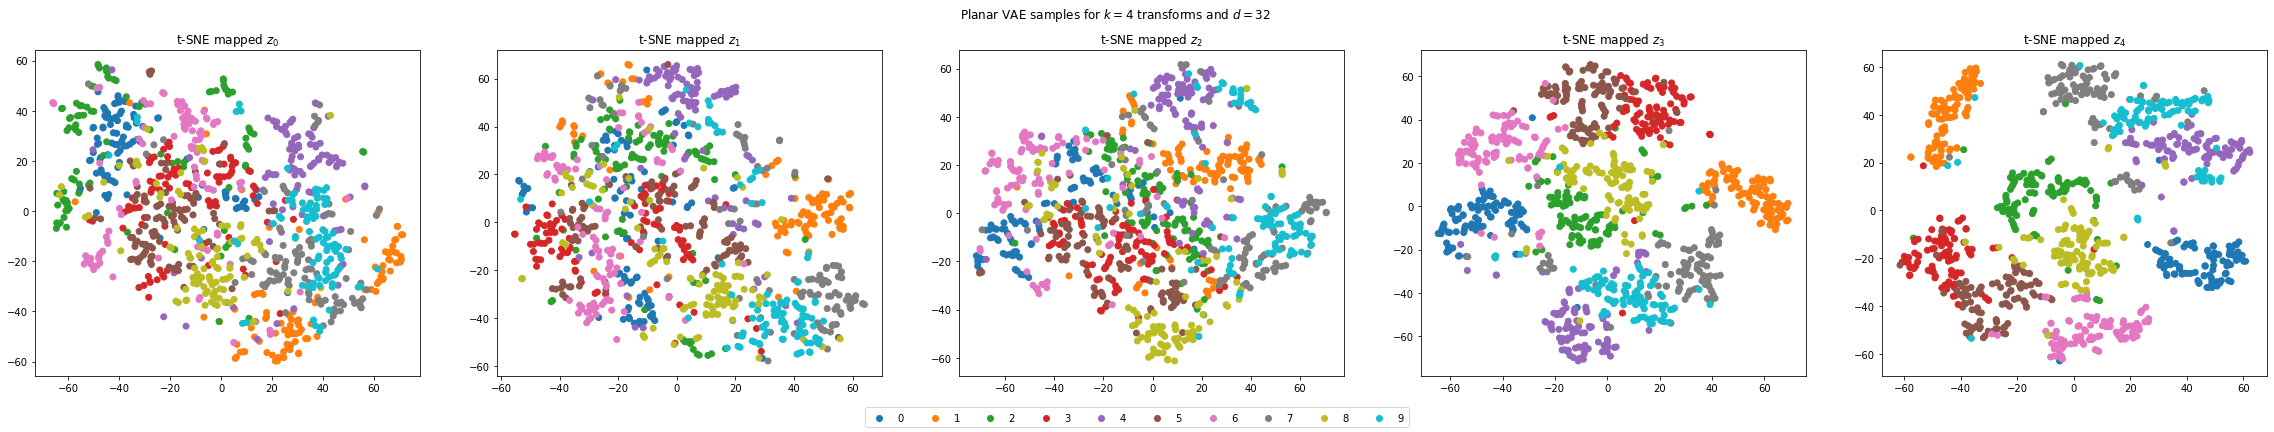

In [20]:
plot_tsne_transforms(X_samples, y_samples, planar_vae_z16)
plt.suptitle('Planar VAE samples for $k={}$ transforms and $d=32$'.format(n_flows))
plt.show()

### Triangular Sylvester VAE

In [21]:
n_flows = 4
tsnf_flow = Flow.uniform(n_flows, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
tsnf_vae = train_vae(x_train, x_test, tsnf_flow, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 257us/sample - loss: 0.3095 - val_loss: 0.2699
Epoch 2/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2627 - val_loss: 0.2481
Epoch 3/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2435 - val_loss: 0.2373
Epoch 4/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2351 - val_loss: 0.2289
Epoch 5/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2272 - val_loss: 0.2214
Epoch 6/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.2203 - val_loss: 0.2151
Epoch 7/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2148 - val_loss: 0.2102
Epoch 8/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2103 - val_loss: 0.2087
Epoch 9/10
60000/60000 [==============================] - 10s 164us/sample - l

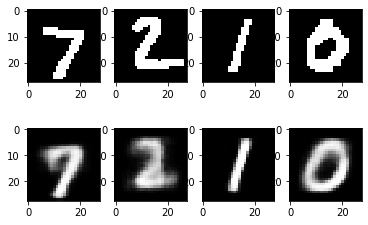

In [22]:
x_pred = tsnf_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

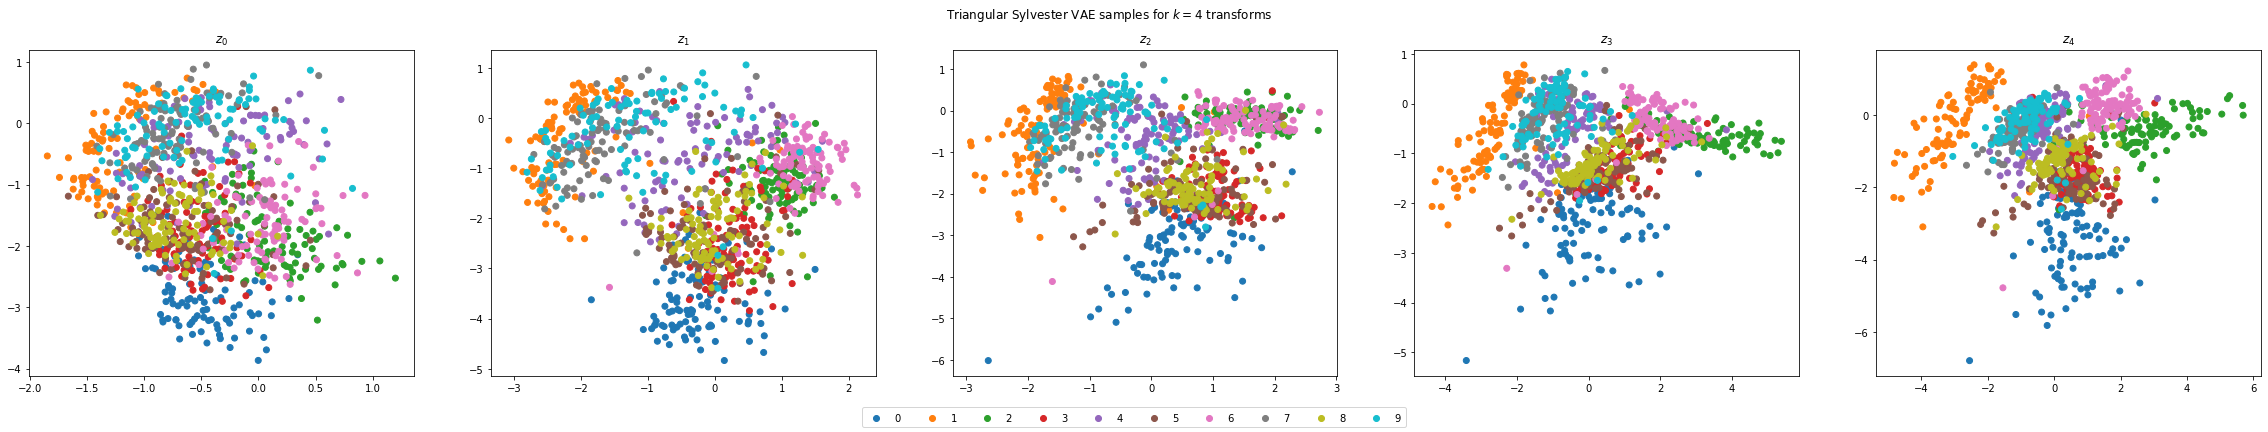

In [23]:
plot_transforms(X_samples, y_samples, tsnf_vae)
plt.suptitle('Triangular Sylvester VAE samples for $k={}$ transforms'.format(n_flows))
plt.show()

In [24]:
tsnf_vae_z16 = train_vae(x_train, x_test, tsnf_flow)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 241us/sample - loss: 0.2036 - val_loss: 0.1452
Epoch 2/10
60000/60000 [==============================] - 10s 169us/sample - loss: 0.1382 - val_loss: 0.1285
Epoch 3/10
60000/60000 [==============================] - 10s 167us/sample - loss: 0.1265 - val_loss: 0.1209
Epoch 4/10
60000/60000 [==============================] - 10s 169us/sample - loss: 0.1198 - val_loss: 0.1154
Epoch 5/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1148 - val_loss: 0.1103
Epoch 6/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1108 - val_loss: 0.1080
Epoch 7/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1077 - val_loss: 0.1053
Epoch 8/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1054 - val_loss: 0.1027
Epoch 9/10
60000/60000 [==============================] - 10s 168us/sample - l

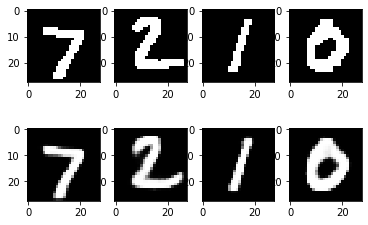

In [25]:
x_pred_tsnf = tsnf_vae_z16.predict(x_test)
plot_images(x_test.squeeze(), x_pred_tsnf)

transforms: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


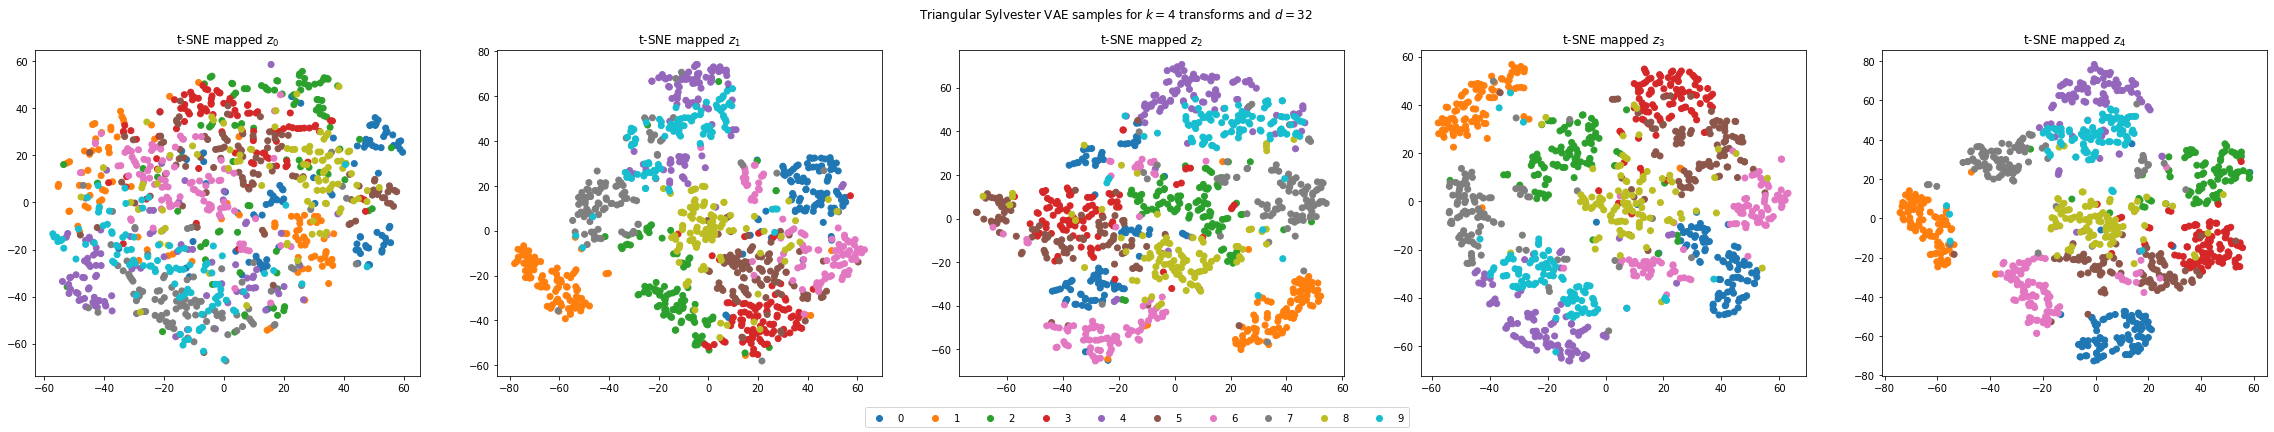

In [26]:
plot_tsne_transforms(X_samples, y_samples, tsnf_vae_z16)
plt.suptitle('Triangular Sylvester VAE samples for $k={}$ transforms and $d=32$'.format(n_flows))
plt.show()

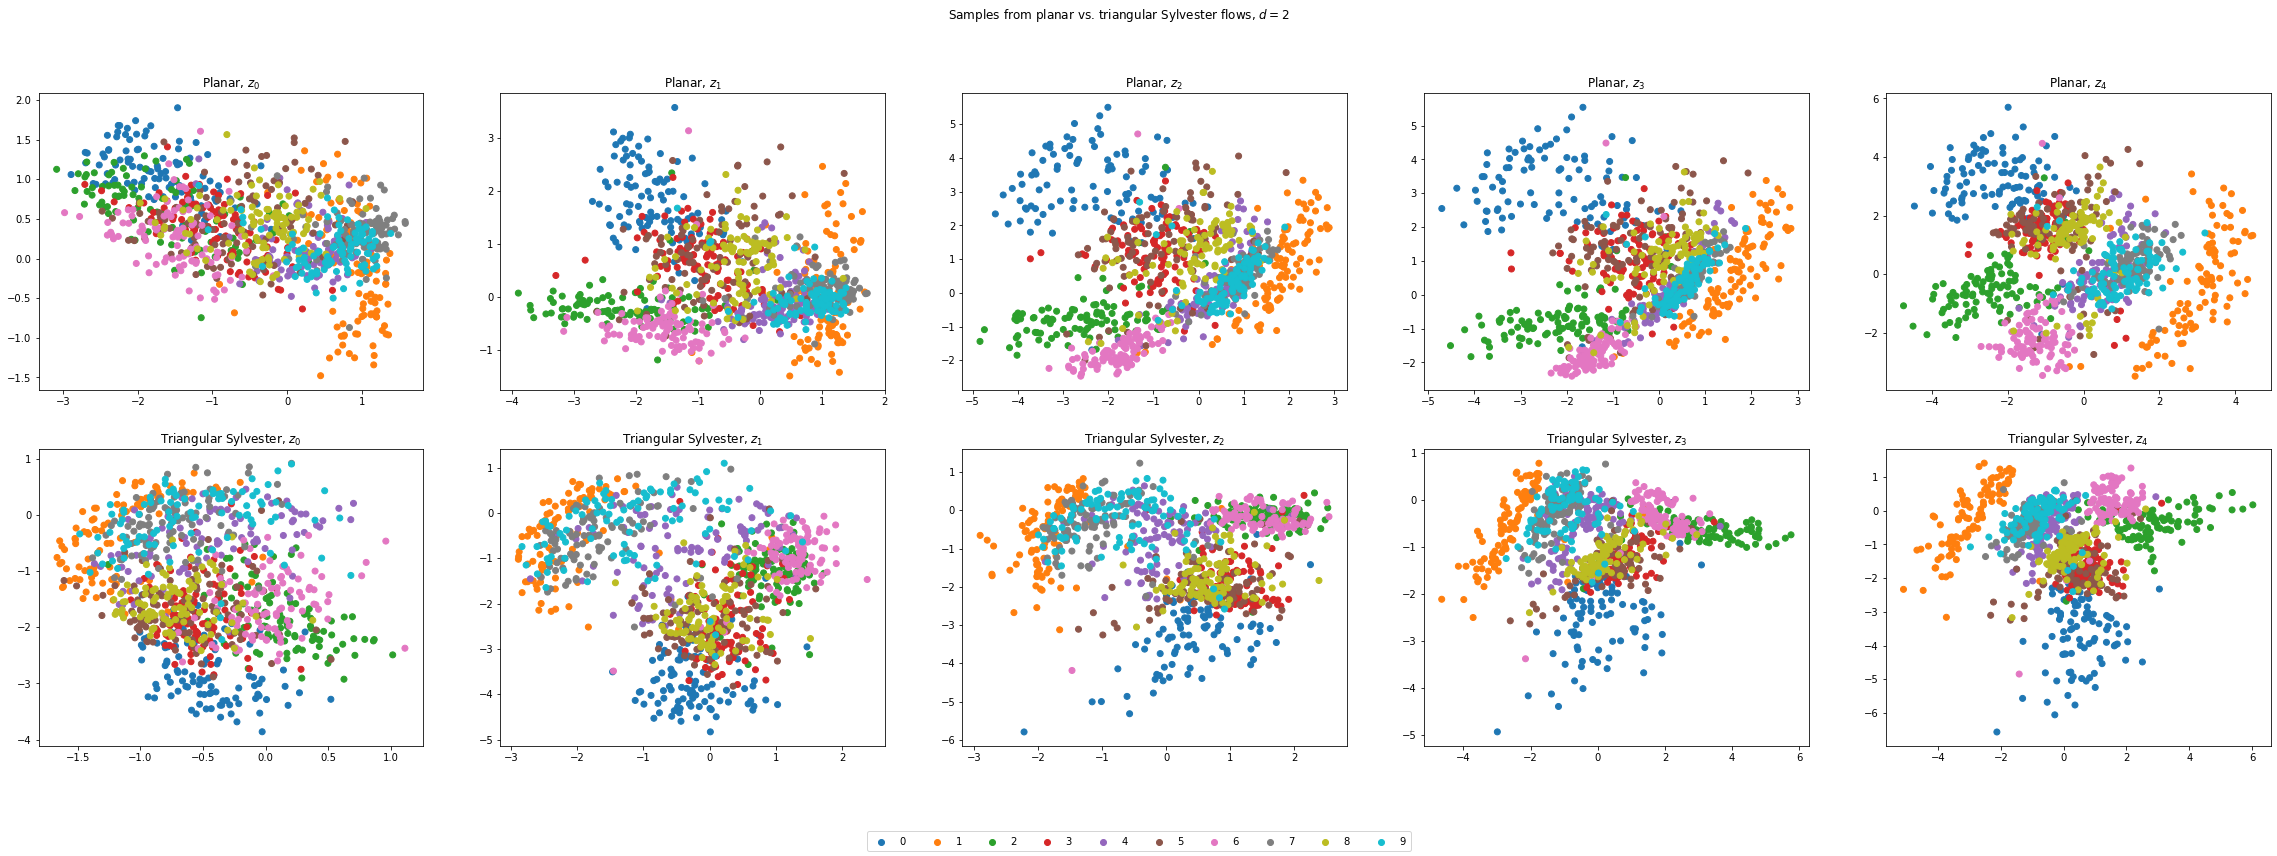

In [45]:
plot_transforms_multi(X_samples, y_samples, [planar_vae, tsnf_vae], ['Planar', 'Triangular Sylvester'])
plt.suptitle('Samples from planar vs. triangular Sylvester flows, $d=2$')
plt.show()

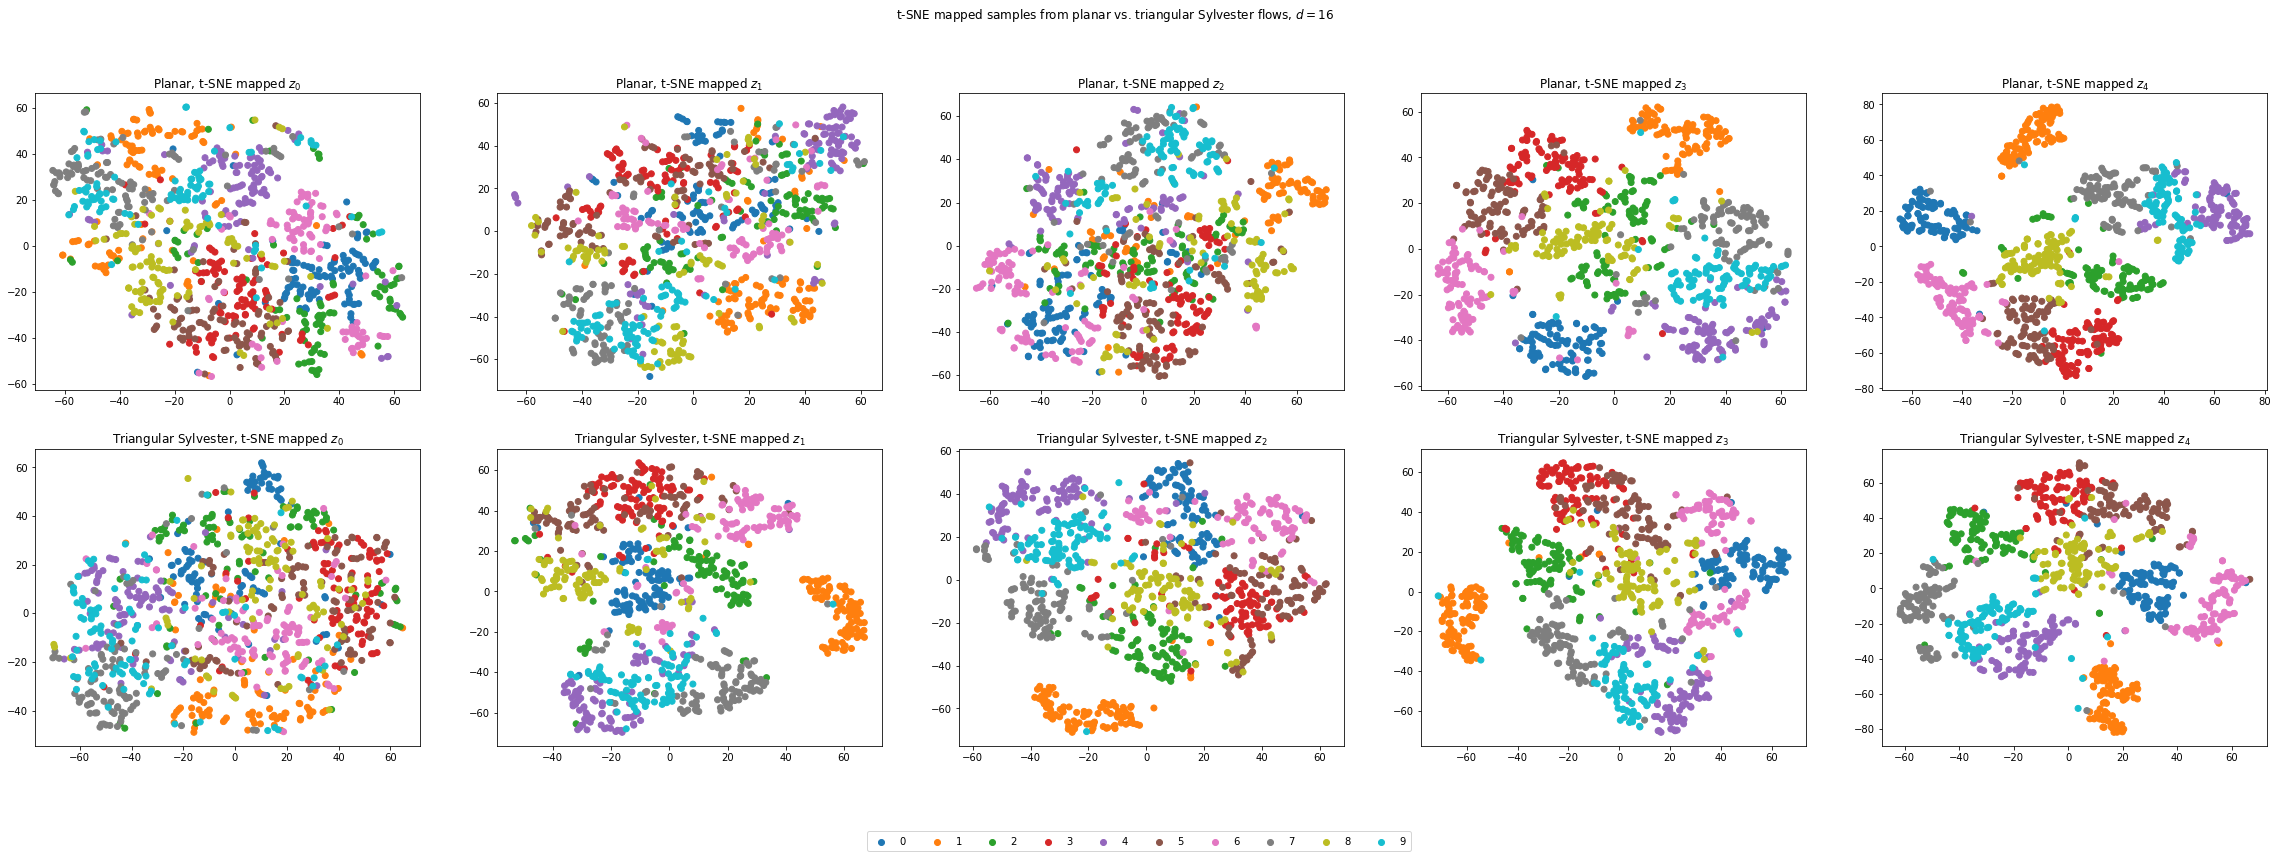

In [53]:
plot_tsne_transforms_multi(X_samples, y_samples, [planar_vae_z16, tsnf_vae_z16], ['Planar', 'Triangular Sylvester'])
plt.suptitle('t-SNE mapped samples from planar vs. triangular Sylvester flows, $d=16$')
plt.show()

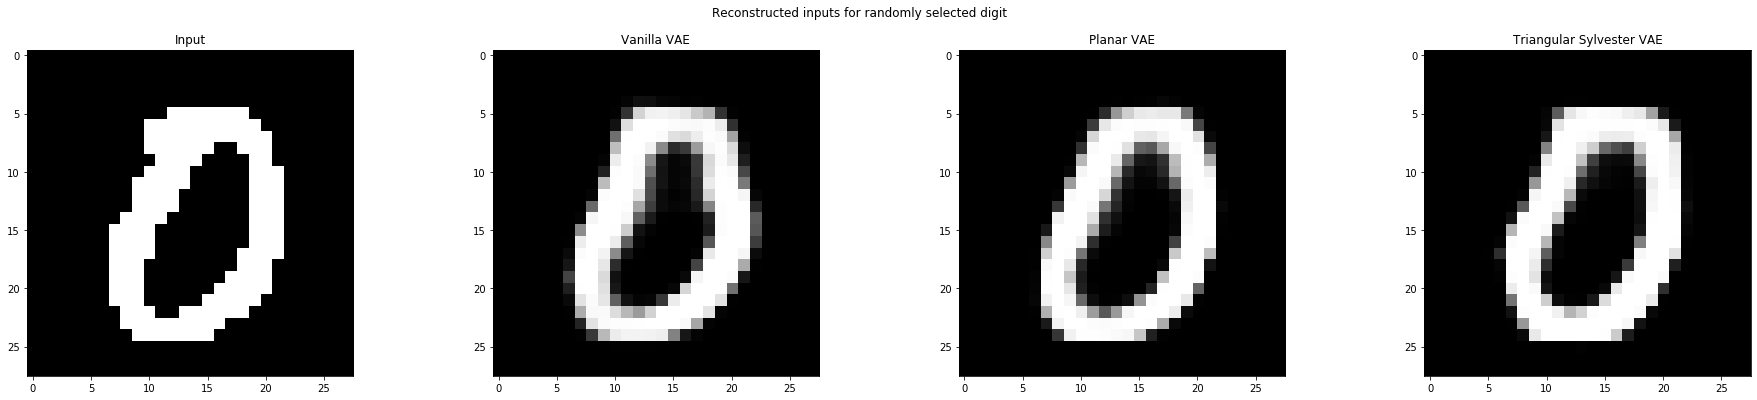

In [93]:
t = np.random.randint(0, len(X_test))
fig, axs = plt.subplots(1, 4, figsize=(4*8,6))
axs[0].imshow(X_test[t], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(x_pred_vae[t].squeeze(), cmap='gray')
axs[1].set_title('Vanilla VAE')
axs[2].imshow(x_pred_planar[t].squeeze(), cmap='gray')
axs[2].set_title('Planar VAE')
axs[3].imshow(x_pred_tsnf[t].squeeze(), cmap='gray')
axs[3].set_title('Triangular Sylvester VAE')
plt.suptitle('Reconstructed inputs for randomly selected digit')
plt.show()